I'm gonna overwrite a lot of this notebook's old content. I changed the way I'm calculating wt, and wanna test that my training worked. 

In [1]:
from pearce.emulator import OriginalRecipe, ExtraCrispy, SpicyBuffalo
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [2]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
training_file = '/scratch/users/swmclau2/xi_zheng07_cosmo_lowmsat/PearceRedMagicXiCosmoFixedNd.hdf5'
#training_file = '/u/ki/swmclau2/des/PearceRedMagicXiCosmoFixedNdLowMsat.hdf5'
test_file = '/scratch/users/swmclau2/xi_zheng07_cosmo_test_lowmsat/PearceRedMagicXiCosmoFixedNd_Test.hdf5'
#test_file = '/u/ki/swmclau2/des/PearceRedMagicXiCosmoFixedNdLowMsatTest.hdf5'

em_method = 'gp'
split_method = 'random'

In [4]:
a = 1.0
z = 1.0/a - 1.0

In [5]:
fixed_params = {'z':z}#, 'cosmo': 0}#, 'r':24.06822623}

In [6]:
v = np.loadtxt('/home/users/swmclau2/Git/pearce/bin/optimization/sloppy_joes_result_sb.npy')

In [7]:
v

array([ 13.18189888,   2.62504077,   4.84099024,   2.27002466,
         3.01761929,   4.65119604,   3.91045593,   4.59410252,
         3.97308517,   0.88579505,   5.17733145,   0.53321126,
         3.4534558 ,  -0.6288115 ,   5.55706351,   1.39911448,
         1.77251549,   4.53312541,   3.99664755,   4.19044211,
         2.8003866 ,  -0.1933706 ,   4.11794288,  -0.93124973,   1.73371894])

In [7]:
param_names = ['ombh2', 'omch2', 'w0', 'ns', 'ln10As', 'H0', 'Neff', 'logM0', 'sigma_logM', 'logM1', 'alpha']

In [8]:
pnames = ['bias', 'amp']
pnames.extend(param_names)
pnames.append('amp')
pnames.extend(param_names)

In [9]:
from collections import defaultdict
metric = defaultdict(list)
for val, pname in zip(v, pnames):
    metric[pname].append(val)

In [10]:
np.random.seed(0)
emu = SpicyBuffalo(training_file, method = em_method, fixed_params=fixed_params,
                 custom_mean_function = 'linear', downsample_factor = 0.01)

/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:287: UserWarning: WARNING: NaN detected. Skipped 21 points in training data.
  warnings.warn('WARNING: NaN detected. Skipped %d points in training data.' % (num_skipped))


In [11]:
emu._ordered_params

OrderedDict([('ombh2', (0.02066455, 0.02371239)),
             ('omch2', (0.10121810000000001, 0.13177679999999997)),
             ('w0', (-1.399921, -0.56584860000000003)),
             ('ns', (0.92784619999999995, 0.99744959999999994)),
             ('ln10As', (3.0009000000000001, 3.179424)),
             ('H0', (61.694719999999997, 74.76751999999999)),
             ('Neff', (2.6212499999999999, 4.2787499999999996)),
             ('logM0', (13.1, 14.6)),
             ('sigma_logM', (0.050000000000000003, 0.29999999999999999)),
             ('logM1', (13.1, 14.6)),
             ('alpha', (0.80000000000000004, 1.2))])

In [39]:
emu.scale_bin_centers

array([  0.09581734,   0.13534558,   0.19118072,   0.27004994,
         0.38145568,   0.53882047,   0.76110414,   1.07508818,
         1.51860241,   2.14508292,   3.03001016,   4.28000311,
         6.04566509,   8.53972892,  12.06268772,  17.0389993 ,
        24.06822623,  33.99727318])

In [40]:
rbins = np.logspace(-1.1, 1.6, 19)
print (rbins[1:]+rbins[:-1])/2

[  0.09581733   0.13534558   0.19118072   0.27004994   0.38145568
   0.53882047   0.76110414   1.07508817   1.51860241   2.14508292
   3.03001016   4.28000311   6.04566509   8.53972892  12.06268772
  17.0389993   24.06822623  33.99727318]


In [41]:
params = {}
for pname in emu.get_param_names():
    if pname == 'r':
        continue
    low, high = emu.get_param_bounds(pname)
    params[pname] = np.random.uniform(low, high)
    
print params

{'logM1': 14.267701848157271, 'Neff': 3.6095427706197905, 'logM0': 13.578807613765713, 'sigma_logM': 0.2502193887675708, 'H0': 73.31620420249872, 'w0': -0.5886073500474833, 'omch2': 0.10271736946651576, 'ln10As': 3.0459840518637358, 'alpha': 1.031390598923265, 'ns': 0.9832511796584299, 'ombh2': 0.021913242278466367}


In [42]:
pred_y = emu.emulate_wrt_r(params)[0]
print pred_y

[ 3.22366054  3.05409368  2.83904001  2.61804409  2.37587608  2.1381192
  1.86466279  1.75922985  1.63397902  1.37624469  1.12380836  0.90423076
  0.6566825   0.39443203  0.17182344 -0.10830868 -0.34115451 -0.65429979]


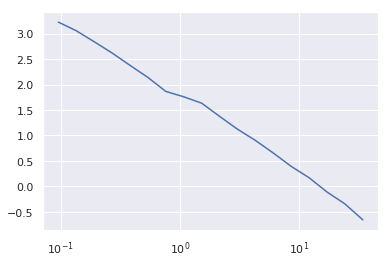

In [43]:
plt.plot(emu.scale_bin_centers, pred_y)
plt.xscale('log')

In [44]:
gof = emu.goodness_of_fit(test_file, statistic = 'frac')
#print gof.mean(), np.median(gof)
for g in gof:
    print g.mean(), np.median(g)

0.149645682086 0.128655888762
0.133912531222 0.113236243993
0.11784951473 0.0992146285554
0.101251700231 0.0778498837237
0.0836126151693 0.0641122730924
0.0691992859729 0.0528876931009
0.0516978413316 0.0354743470897
0.0345398276494 0.0239655902781
0.0289404338408 0.0192863040181
0.0308574628869 0.0192242389498
0.0351647140065 0.0225004904159
0.0381018912368 0.0180067464332
0.0262604537032 0.0154358194331
0.0219092213787 0.0149267065205
0.0257505426455 0.0156485486958
0.0169685122815 0.00868868127145
0.0187598528761 0.0137360634496
0.0282343590017 0.0231763810956


In [23]:
pred_y, data_y = emu.goodness_of_fit(test_file, statistic = None)

In [24]:
test_x, _, _, _ = emu.get_data(test_file, fixed_params=fixed_params)

train_x, _, _, _ = emu.get_data(training_file, fixed_params=fixed_params)

emu.get_param_names()

/home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/emu.py:287: UserWarning: WARNING: NaN detected. Skipped 21 points in training data.
  warnings.warn('WARNING: NaN detected. Skipped %d points in training data.' % (num_skipped))


['ombh2',
 'omch2',
 'w0',
 'ns',
 'ln10As',
 'H0',
 'Neff',
 'logM0',
 'sigma_logM',
 'logM1',
 'alpha']

In [25]:
print test_x.shape, train_x.shape
print test_x.shape[0]/(7*emu.n_bins), train_x.shape[0]/(40*emu.n_bins)

(126000, 12) (719979, 12)
1000 999


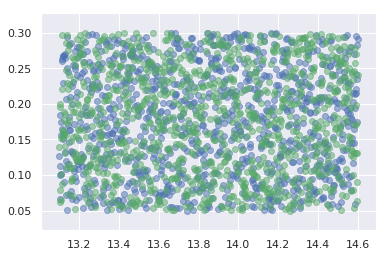

In [28]:
idx1, idx2 = -3, -4
plt.scatter(test_x[0:1000*emu.n_bins:emu.n_bins, idx1], test_x[0:1000*emu.n_bins:emu.n_bins, idx2], alpha = 0.5)
plt.scatter(train_x[0:1000*emu.n_bins:emu.n_bins, idx1], train_x[0:1000*emu.n_bins:emu.n_bins, idx2], color = 'g', alpha = 0.5)

In [49]:
resmat = np.zeros( (len(pred_y), pred_y[0].shape[0]))
for bin_no in xrange(len(pred_y)):
    py, dy = pred_y[bin_no], data_y[bin_no]
    resmat[bin_no] = py - dy
    
    #print np.sqrt(np.mean( (py - dy)**2)*py.shape[0]/(py.shape[0]-1) )

In [50]:
scovmat = resmat.dot(resmat.T)/(len(pred_y[0])-1)

In [51]:
print np.sqrt(np.diag(scovmat))

[ 0.07324394  0.06677896  0.05704395  0.05060372  0.04064217  0.0331524
  0.02426894  0.01773689  0.01600837  0.01799117  0.02079775  0.0247824
  0.01694155  0.01307426  0.01725277  0.01279105  0.01174972  0.01832541]


In [52]:
%%bash
cp /home/users/swmclau2/.local/lib/python2.7/site-packages/pearce/emulator/default_metrics.pkl /home/users/swmclau2/Git/pearce/emulator/default_metrics.pkl

cp: cannot create regular file ‘/home/users/swmclau2/Git/pearce/emulator/default_metrics.pkl’: No such file or directory


In [53]:
#print g.mean(), np.median(g)

In [54]:
plt.hist(y)

NameError: name 'y' is not defined

In [ ]:
plt.hist(pred_y)

In [ ]:
plt.hist(emu.y)

In [ ]:
plt.hist(np.log10(gof));

In [ ]:
plt.hist(emu.y)

In [ ]:
for i in xrange(50):    
    params = {}

    for pname in emu.get_param_names():
        if pname == 'r':
            continue
        low, high = emu.get_param_bounds(pname)
        params[pname] = np.random.uniform(low, high)
    pred_y = emu.emulate(params)[0]
    print pred_y
    #print params

In [ ]:
for i, (g, r) in enumerate(zip(gof, emu.scale_bin_centers)):
    print r, g.mean(), np.median(g)
    #plt.hist(np.log10(g))
    #plt.show()

In [ ]:
n_cosmo_params = 7
loo_cosmo = emu.x[0, 0,  :n_cosmo_params]

loo_cosmo_idxs = np.all(emu.x[:, :,:n_cosmo_params] == loo_cosmo, axis =2)
train_x, train_y, train_yerr = emu.x[~loo_cosmo_idxs, :], emu.y[ ~loo_cosmo_idxs], emu.yerr[ ~loo_cosmo_idxs]
test_x, test_y, test_yerr = emu.x[loo_cosmo_idxs, :], emu.y[loo_cosmo_idxs], emu.yerr[loo_cosmo_idxs]

In [ ]:
model = emu._emulator
model.compute(train_x, train_yerr)

In [ ]:
pred_y = model.predict(train_y, test_x, False, False, False)*emu._y_std + emu._y_mean


In [ ]:
np.mean(np.abs((pred_y-test_y)/test_y))
#np.mean(np.abs((pred_y-train_y)/train_y))

In [ ]:
        queue_skipper: True
        system: sherlock
        n_jobs: 400
        max_time: 6
resids = np.abs(emu.y*emu._y_std+emu._y_mean - ypred)

In [ ]:
np.mean(resids/(emu.y*emu._y_std+emu._y_mean))

In [ ]:
ypred.mean(), emu._y_mean

In [ ]:
test_gof = emu.goodness_of_fit(test_file, statistic = 'log_frac')
print test_gof.mean()

In [ ]:
test_gof = emu.goodness_of_fit(test_file, statistic = 'frac')
print test_gof.mean()

In [ ]:
plt.hist(np.log10(test_gof));

In [ ]:
test_x

In [ ]:
(emu.x*emu._x_std) + emu._x_mean

In [ ]:
emu.get_param_names()

In [ ]:
test_x_white, test_y_white = (test_x - emu._x_mean)/(emu._x_std + 1e-5), (test_y - emu._y_mean)/(emu._y_std + 1e-5)

In [ ]:
model = emu._emulator

In [ ]:
pred_y_white = model.predict(emu.y, test_x_white, False, False, False)

In [ ]:
pred_y = pred_y_white*emu._y_std + emu._y_mean

In [ ]:
plt.plot(pred_y[:100], label = 'pred')
plt.plot(test_y[:100], label = 'truth')

plt.legend(loc = 'best')

In [ ]:
test_y.mean(), emu._y_mean, pred_y.mean()

In [ ]:
test_y.std(), emu._y_std, pred_y.std()

In [ ]:
plt.hist(pred_y_white, bins = np.linspace(-3, 3, 100), label = 'Pred')
plt.hist(test_y_white, bins = np.linspace(-3, 3, 100), label = 'Test', alpha = 0.4);
plt.legend(loc = 'best')